## Pipeline | Transformadores | cross-validation | feature selection 

### Load Libraries 📘

In [1]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [15]:
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
#warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

A modo de muestra, extraemos una pequeña porción del dataset de la competición de Kaggle: https://www.kaggle.com/c/jane-street-market-prediction

In [5]:
%%time
import pandas as pd
import numpy as np
import zipfile
#Load data
#Extract the first 10,000 rows
zf = zipfile.ZipFile('data/jane-street-market-prediction.zip') 
df_train = pd.read_csv(zf.open('train.csv'), nrows=10000)

Wall time: 2.33 s


### Preprocesamiento de los datos  
Según las necesidades de los datos que nos describe en la competición de Kaggle.

In [6]:
##PREPROCESING##

# Drop rows with 'weight'=0 
df_train = df_train[df_train['weight']!=0]
#df_train = df_train.loc[df_train.weight != 0]

# Create 'action' column (target)
# The objetive is maximise the utility function pi=∑j(weightij∗respij∗actionij) where positive values of resp will increase pi
#df_train['action'] = df_train['resp'].apply(lambda x:x>0).astype(int)
df_train['action'] = (df_train['resp'] > 0).astype('int')

#Select the model´s variables (features alone)
features = [c for c in df_train.columns if 'feature' in c]
#df_train = pd.concat([df_train[features],df_train.action], axis=1)

X = df_train[features]
y = df_train['action']

In [7]:
# Train and test data
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3)

#### Eliminamos valores nulos e infinitos

In [8]:
#Check that we have removed all other null and infinite values
train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
#First estrategy
#Fill nan values with 0
#train_x.fillna(0,inplace=True)
#test_x.fillna(0,inplace=True)

#Second estrategy
#Fill nan values with median
train_median = train_x.median()
train_x = train_x.fillna(train_median)
test_x = test_x.fillna(train_median)
X = X.fillna(train_median)

#Third estrategy
#Lineal Interpolation
#train_x.interpolate(method='linear', inplace=True)

In [10]:
#Check null values
train_x.isnull().sum().sum()

0

In [11]:
#We make sure the values are numeric
train_x.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

### Modelo Básico  

Hemos selecionado ExtraTreesClasifier como modelo con mejor rendimiento en una aproximación al problema que hicimos previamente con PyCaret (AutoML)  

Ejecutamos antes una función para evaluar y comparar los modelos (metricas_modelos())

In [13]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print("La matriz de confusión es ")
    print(confusion_matrix)

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', auc(false_positive_rate, recall))

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

El rendimiento el modelo es: 1.00000
La matriz de confusión es 
[[2718    0]
 [   0 2791]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


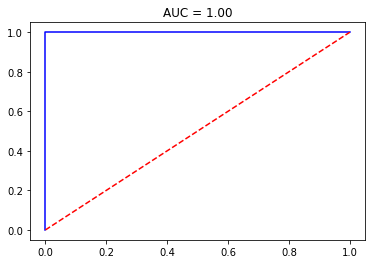

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(train_x, train_y)
print(u'El rendimiento el modelo es: %0.5f' % etc.score(train_x, train_y))
y_pred_train = etc.predict(train_x)
metricas_modelos(train_y, y_pred_train)

Probamos en test tambien para ver el sobreajuste

La matriz de confusión es 
[[906 291]
 [317 847]]
Precisión: 0.7424819991529014
Exactitud: 0.7442882249560633
Exhaustividad: 0.7276632302405498
F1: 0.735881841876629
AUC: 0.7422777304084955


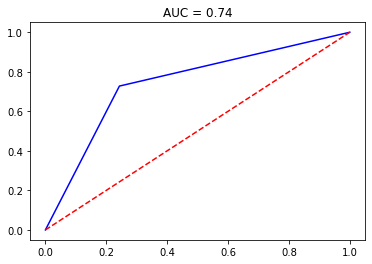

In [16]:
#Check Overfitting in tets df
y_pred_test = etc.predict(test_x)
metricas_modelos(test_y, y_pred_test)

Se puede apreciar un **sobrajuste excesivo** en el modelo generado.  
Para intentar mejorarlo y automatizar el proceso para hacer pruebas, vamos a:
* Automatizar el proceso con Pipeline y tranformadores
* Selección de características y reducción de dimensionalidad (Ahora 130 variables). Para generalizar el modelo y disminuir el tiempo de procesado, ya que en este conjunto de datos son más de 2 millones de filas y entrenar con todo el conjunto de datos costaría mucho tiempo y recursos de memoria.
* Validación cruzada para selecionar hiperparámetros y disminuir el sobreajuste
* Canalizar todos estos procesos en una sola operación


## Automatización del proceso | Pipeline  
Sklearn dispone de unos métodos para canalizar en un sólo paso todos los subprocesos que se pueden desarrollar en un modelaje y que ayudan a llevarlo a producción o a mejorarlo. Desde el preprocesamiento de los datos (que hemos hecho previamente) y las columnas en las que se aplicará (Transformadores), normalización, selección de características, reducción de la dimensionalidad hasta finalmente el modelo a entrenar (estimador). 

### Tranformadores  

Es posible hacer el preprocesamiento de los datos con estos transformadores estandar que vienen por defecto en SKlearn (llamados estimators) o también hacerlos de forma más personalizada. De esta forma el preprocesamiento formará parte y se integrará en todo el modelo a entrenar.  

Todas las transformaciones de conjunto de datos en Sklearn: https://scikit-learn.org/stable/data_transforms.html


#### Elegir variables o columnas para transformar
El método de transformación debe comenzar eligiendo las características/columnas relevantes para la transformación (por ejemplo, características numéricas, características categóricas o columnas con un nombre común). Lo más habitual es que se agrupen por columnas numéricas por un lado y categóricas por otro.

In [22]:
#If you want to select a particular type of Column o specific Columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
select_specific_columns = [c for c in X.columns if 'feature' in c]

#### Imputación de valores perdidos  

1. Imputación Univariante  
Se utiliza el estimador `SimpleImputer` que solamente sustituyen el valor perdido por otro valor fijo. Ya sea la media o la mediana de toda esa columna, por ejemplo:  
`SimpleImputer(missing_values=np.nan, strategy='mean' o 'median')` # Para rellenar con la media.  
`SimpleImputer(strategy="constant" fill_value= 0)` # Para rellenar con 0. 

2. Imputación Multivariante  
Se utiliza el estimador `IterativeImputer` que modela los valores perdidos de forma diferente en función del resto de los datos al rededor del dato perdido. Una especie de regresión que varia según evolucionan los datos:   
`IterativeImputer(max_iter=10, random_state=0)`  

3. Otros estimadores de imputación
`KNNImputer(n_neighbors=2, weights="uniform")` # Se rellenan valores en función de los vecinos más cercanos.  
`MissingIndicator(missing_values=np.nan)` #Nos permite guardar en otra columna dónde estaban los valores faltantes por si es necesaria esa información.   

Más información en: https://scikit-learn.org/stable/modules/impute.html

#### Normalizar datos  
En muchas de las ocasiones es necesario normalizar los datos o estandarizarlos a una escala común como proceso previo al resto de operaciones. En nuestro caso como vamos a realizar una reducción de la dimensionalidad del conjunto de datos es necesario este paso previo en las características numéricas.  
- `StandardScaler()` o `Normalize()` #Eliminando la media y escalando a la varianza 1  
- `MinMaxScaler()` o `MaxAbsScaler()` #Escalar características a un rango determinado  
- `RobustScaler()`# Cuando se tienen muchos datos atípicos  

Más info: https://scikit-learn.org/stable/modules/preprocessing.html#normalization


#### Variables categóricas  
`OneHotEncoder()` #Genera columnas dummies binaria 1/0 con las categorias de esa variable  
`CountVectorizer()` # Vectoriza un texto que este como dato en una columna


**En nuestro caso se imputa la mediana a los valores faltantes y se normalizan los datos numéricos**

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#transformations that we apply to numeric variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

## this imputer imputes with an arbitrary value in categorical features
#categorical_transformer = Pipeline(steps=[('imputer',
#            SimpleImputer(strategy='constant', fill_value='Missing'))]) #

#### ColumnTransformer  
Con este objeto `ColumnTransformer()` uniremos los diferentes estimadores/transformadores que se realizaran en diferentes columnas. De tal forma que hace el procesado en paralelo y luego lo une para pasar al siguiente paso de la canalización.  

El formato será: `ColumnTransformer(transformers=[('nombre elegido', trasformador, ['listado con las columnas a aplicar'])]`  
En nuestro caso no hará falta unir diferentes tipos de columnas al ser todas numéricas

In [25]:
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, select_specific_columns)])
        #('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)]) #Podriamos añadir también estimador categorico
                                                                  #We could also add categoric estimator

Se une todo el Preproceso con el modelo en una sola canalización.

In [27]:
%%time

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', etc)])

#pipe = Pipeline([('model', model)])

pipe.fit(X, y)

#pipe.score(train_x, train_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe.score(train_x, train_y))

El rendimiento el modelo es: 1.00000
Wall time: 2.27 s


In [28]:
#Vemos el sobreajuste
#Check overfit in the df test
#pipe.score(test_x, test_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe.score(test_x, test_y))

El rendimiento el modelo es: 1.00000


Por ahora conseguimos menos sobreajuste que aplicando el modelo directamente.  
Vamos a seguir mejorando el proceso.

### Reducción de dimensionalidad   
La reducción de dimensionalidad es el proceso de expresar datos de alta dimensión en un número reducido de dimensiones de modo que cada uno contenga la mayor cantidad de información. La reducción de dimensionalidad se puede utilizar para la visualización de datos de alta dimensión o para acelerar los modelos de aprendizaje automático al eliminar características correlacionadas o de baja información.  

- #### No supervisada

1. **PCA**: Análisis de Componentes Principales  
El método `decomposition.PCA()`, busca una combinación de características (componentes) que capturen bien la variación de las características originales. Es un método popular para reducir la dimensionalidad de los datos dibujando varios vectores ortogonales (perpendiculares) en el espacio de características para representar el número reducido de dimensiones. El número de  variable  representa el número de dimensiones que tendrán los datos reducidos. En el caso de la visualización, por ejemplo, serían dos dimensiones. Este módulo es el más usado para reducir la dimensionalidad.

2. Proyecciones aleatorias  
El módulo `random_projection`proporciona varias herramientas para la reducción de datos mediante proyecciones aleatorias.  
Más info: https://scikit-learn.org/stable/modules/random_projection.html#random-projection

3. Aglomeración de características  
El módulo `cluster.FeatureAgglomeration`, aplica el agrupamiento jerárquico para agrupar características que se comportan de manera similar.  
Más info: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration

4. Selección de las mejores características  
No es un método en sí de reducción de dimensionalidad, pero supone una reducción de caracteristicas al seleccionar las mejores ya sea en número o en porcentaje. Se construye con los constructores `SelectKBest()` y `SelectPercentile()` para seleccionar crear objetos que permitan seleccionar las k mejores características o un porcentaje de las mismas respectivamente para la creación de un modelo. En ambos casos se ha de indicar el criterio a utilizar para ordenarlas. En scikit-learn existen dos métodos que se pueden utilizar según el tipo de problema con el que se esté trabajando: `f_regression` para modelos de regressión y `chi2` para modelos de clasificación.  

5. Eliminar características con baja varianza  
Eliminar las características que no varían una cantidad suficiente.  
Se puede utilizar el constructor `VarianceThreshold` al que se le ha de indicar la varianza mínima que ha de tener una característica, por ejemplo `VarianceThreshold(threshold = 0.25)`.  
Tambien se podría usar `Factor de inflación de la varianza (VIF)` pero es una función que es más dificil integrar en Pipeline.


- #### Supervisada  

1. El análisis discriminante lineal  (**LDA**, que no debe confundirse comúnmente con la asignación de Dirichlet latente) es otro método de reducción de dimensionalidad. La principal diferencia entre LDA y PCA es que LDA es un algoritmo supervisado, lo que significa que tiene en cuenta tanto  x  como  y . El PCA solo considera  x , por lo tanto, es un algoritmo no supervisado. PCA intenta mantener la estructura (varianza) de los datos basándose puramente en distancias entre puntos, mientras que LDA prioriza la separación limpia de clases.

#### SelectkBest

In [32]:
#Uso de SelectKbest

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, f_regression, chi2
#For that you have to separate SelectKBest from fit_transform
var_sk = SelectKBest(f_classif, k = 5) #Pasariamos de tener 130 a las 5 más predictivas
var_sk.fit_transform(X, y)
#var_sk.get_support()

k_selection = X.loc[:, var_sk.get_support()]
k_selection.columns

Index(['feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_39'], dtype='object')

In [35]:
%%time

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('Best', SelectKBest(f_regression, k = 5)),
                       ('model', etc)])

#pipe = Pipeline([('model', model)])

pipe.fit(X, y)
#pipe.score(train_x, train_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe.score(train_x, train_y))

El rendimiento el modelo es: 0.99492
Wall time: 1.11 s


In [36]:
#Vemos el sobreajuste
#Check overfit in the df test
#pipe.score(test_x, test_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe.score(test_x, test_y))

El rendimiento el modelo es: 0.99492


#### PCA

In [38]:
# Reducción de dimensionalidad con PCA
from sklearn.decomposition import PCA, NMF

#Repeat for feature selection. For that you have to separate SelectKBest from fit_transform
pca_sk = PCA(.90) #Divide into components that explain at least 90% of the variance (information)
pca_sk.fit_transform(X, y)
#var_sk.get_support()

#k_selection = X.loc[:, pca_sk.get_support()]
#k_selection.columns
pca_sk.explained_variance_ratio_
#To explain 90% of the variance is reduced from 130 characteristics to 14 components
print('Nº de componentes reducidas para explicar el 90% de la varianza:', len(pca_sk.explained_variance_ratio_))

Nº de componentes reducidas para explicar el 90% de la varianza: 14


In [41]:
##Comando para conocer los parámetros que se pueden configurar
etc.get_params().keys()
pca_sk.get_params().keys()

dict_keys(['copy', 'iterated_power', 'n_components', 'random_state', 'svd_solver', 'tol', 'whiten'])

In [58]:
%%time

pca= PCA(n_components=14)

pipe_pca = Pipeline(steps=[('preprocessor', preprocessor),
                       ('pca', pca),
                       ('model', etc)])
pipe_pca.fit(X, y)
#pipe.score(train_x, train_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe_pca.score(train_x, train_y))

El rendimiento el modelo es: 1.00000
Wall time: 1.89 s


In [43]:
#Vemos el sobreajuste
#Check overfit in the df test
#pipe_pca.score(test_x, test_y)
print(u'El rendimiento el modelo es: %0.5f' % pipe_pca.score(test_x, test_y))

El rendimiento el modelo es: 1.00000


Cuando observamos sobreajuste o modelos demasiado perfectos, como en el caso que precede, es conveniente realizar una **validación cruzada** para reafirmar los resultados y ver cómo es el rendimiento en este caso.

#### LDA  
Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 14, random_state=0)
transformed = lda.fit_transform(X, y)

### Cross Validation  
Nota: En este caso, un error típico es utilizar los conjuntos de datos de entrenamiento separados anteriormente. Dado que la validación cruzada ya realiza la separación de datos en el número especificado de conjuntos y valida con datos que el modelo no ha visto, se deben usar **todos los datos**. En este caso hemos usado todos los datos para el entrenamiento y vemos el rendimiento en train y test.  


<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=500>

**Cálculo de las métricas de la validación cruzada**:
`cross_val_score` y `cross_val_predict`  
Cuando el argumento "cv" es un número entero, cross_val_score utiliza por defecto la estrategia de KFold  

Referencia: https://scikit-learn.org/stable/modules/cross_validation.html

In [44]:
%%time
from sklearn.model_selection import cross_val_score, cross_val_predict
# evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds.
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
#print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

Accuracy: 0.603 (0.048)
Wall time: 11.2 s


También se puede usar un iterador de validación cruzada personalizado por ejemplo `RepeatedStratifiedKFold`

In [45]:
%%time
from sklearn.model_selection import RepeatedStratifiedKFold
# evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.758 accuracy with a standard deviation of 0.01
Wall time: 23.1 s


Con este iterador se comprueba una mejora sustancial del rendimiento aunque supone un coste de tiempo computacional, más costoso cuanto mayor sea el dataset.  

Podemos también utilizar `cross_val_predict` para predecir las etiquetas aunque no debe utilizarse para modelar sino simplemente para usar las etiquetas y medir el rendimiento respecto a la y_true que dispongamos.  Además no se pueden itroducir en el argumento "cv" distinta estrategia de cv personalizada, sino solamente Kfold mediante un número entero. Asique solo servirá para estimar el rendimiento pero no para optimizarlo.

In [50]:
print(train_x.shape, test_x.shape)

(5509, 130) (2361, 130)


La matriz de confusión es 
[[2028  690]
 [ 738 2053]]
Precisión: 0.7407878017789072
Exactitud: 0.7484506015311703
Exhaustividad: 0.7355786456467216
F1: 0.7419588001445608
AUC: 0.7408577554944425


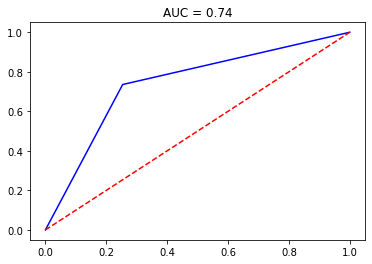

In [49]:
#We represent Accuracy Accuracy and AUC over 5509 rows of train df
y_pred_cv = cross_val_predict(etc,
                         train_x,
                         train_y,
                         cv = 10)

metricas_modelos(train_y, y_pred_cv)

La matriz de confusión es 
[[869 328]
 [379 785]]
Precisión: 0.7005506141465481
Exactitud: 0.7053009883198562
Exhaustividad: 0.6743986254295533
F1: 0.6895037329819939
AUC: 0.7001901230740081


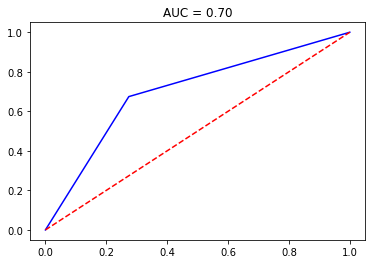

In [51]:
#Tested performance on df test selection (2361 records)
y_pred_cv = cross_val_predict(etc,
                         test_x,
                         test_y,
                         cv = 10)

metricas_modelos(test_y, y_pred_cv)

**Clases de estrategias en los iteradores de Validación Cruzada**:  
- `KFold`| from sklearn.model_selection import KFold  
Se divide todo el dataset (las muestras) en  grupos del mismo tamaño, llamados pliegues. El modelo se entrena con K-1 pliegues y se valida con el que queda y así con todos.  
<img src="https://www.researchgate.net/profile/Fabian_Pedregosa/publication/278826818/figure/fig10/AS:614336141750297@1523480558954/The-technique-of-KFold-cross-validation-illustrated-here-for-the-case-K-4-involves.png" width=300 align=left>  

In [52]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=kf, n_jobs=-1, error_score='raise')
# report performance

print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.541 accuracy with a standard deviation of 0.02


- `RepeatedKFold` | from sklearn.model_selection import RepeatedKFold  
Repite el iterador K-Fold n veces con diferente semilla en cada iteración. Por tanto más pesado computacionalmente.  
Para obtener resultados que se repitan, hay que establecer la ramdon_state  

In [53]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=rkf, n_jobs=-1, error_score='raise')
# report performance

print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.720 accuracy with a standard deviation of 0.00


Se nota una mejora del rendimiento si se repite 2 veces validación cruzada de Kfold (RepeatedKFold).  
  

- ` ShuffleSplit`| from sklearn.model_selection import ShuffleSplit  
Este iterador generará un número definido por el usuario de divisiones de conjuntos de datos de prueba / validación independientes. Las muestras se mezclan de nuevo aleatoriamente en la siguiente iteración y así sucesivamente.  
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0061.png" width=400 align=left>

In [54]:
%%time
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=ss, n_jobs=-1, error_score='raise')
# report performance

print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.749 accuracy with a standard deviation of 0.01
Wall time: 6.73 s


Coseguimos mejorar ligeramente el anterior rendimiento. Tenemos que tener en cuenta que a mayor número de iteraciones más costoso va a ser la computación del entrenamientod el modelo con todos los datos.  

  
- Iteradores estratíficados: `StratifiedKFoldy` y `StratifiedShuffleSplit` | from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit  
Cuando tenemos datos con la **variable objetivo desequilibrada** hacia una clase más que otra, es bueno utilizar este tipo de iteradores estratificados que aseguran que las proporciones relativas de la variable Y se conservan aproximadamente en cada iteración dentro de los pliegues de entrenamiento y validación.  

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png" width=400 align=left>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0091.png" width=400 align=left>  


En nuestro caso al estar bastante balanceada la variable objetivo, no es necesario utilizar este tipo de iterador de validación cruzada.

In [55]:
%%time
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')
# report performance

print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.554 accuracy with a standard deviation of 0.04
Wall time: 4.49 s


Como se puede observar, perdemos rendimiento con el iterador anterior.  

- `RepeatedStratifiedKFold` se puede utilizar para repetir StratifiedKFold n veces con diferente aleatorización en cada repetición.  

In [56]:
%%time
from sklearn.model_selection import RepeatedStratifiedKFold
# evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds.
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(etc, X, y, scoring='accuracy', cv=rskf, n_jobs=-1, error_score='raise')
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("%0.3f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.760 accuracy with a standard deviation of 0.01
Wall time: 22.8 s


# Unión de los diferentes apartados⛓ 

## Optimización del modelo | GridSearchCV
Una vez definido el `Pipeline` es posible utilizar el objeto `GridSearchCV` o `RandomizedSearchCV` para obtener la cantidad de características optimas y el valor de los hiperparámetros más adecuados, en definitiva optimizar el modelo. Además podemos guardar todos los pasos en un sólo proceso y dejarlo preparado para producción al poderse guardar directamente (Persistencia de modelos) libraría pickle.  



Optimizamos los parámetros del modelo con validación cruzada desde `GridSearchCV`

In [61]:
%%time

pca= PCA(n_components=14)

pipe_pca = Pipeline(steps=[('preprocessor', preprocessor),
                       ('pca', pca),
                       ('model', etc)])
#pipe_pca.fit(X, y)

#Ya habíamos entrenado el modelo anteriormente, asique aprovechamos esa tiempo de computación

# Parameters of pipelines can be set using name +‘__’+ parameter names:
param_grid={
        #'pca__n_components': range(4,16,4),
        'model__criterion': ['gini', 'entropy'],
        'model__n_estimators': range(25,100,25),
        'model__max_depth': range(1,100,25),
        #'model__max_features': [100],#range(50,150,50),#grid.best_params_ = {'n_estimators': 100}
        #'min_samples_leaf': range(1,50,5),#grid.best_params_ = {'min_samples_leaf': 1}
        #'min_samples_split': range(1,50,5),
}

ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

etc_pca = GridSearchCV(pipe_pca, param_grid=param_grid, n_jobs=-1, cv=ss)
etc_pca.fit(X, y)
print("Best parameter (CV score=%0.3f):" % etc_pca.best_score_)
print(etc_pca.best_params_)

Best parameter (CV score=0.657):
{'model__criterion': 'entropy', 'model__max_depth': 76, 'model__n_estimators': 75}
Wall time: 19.2 s


Optimizamos los parámetros del modelo con validación cruzada desde `RandomizedSearchCV`.  
A diferencia de GridSearchCV, no se prueban todos los valores de los parámetros, sino que se generan números aleatorios y evalua el rendimiento. Los parametros se memorizan en un discionario. El número de ajustes de parámetros que se prueban viene dado por n_iter.

In [64]:
np.random.randint(2, size=10)

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [65]:
%%time
from scipy.stats import uniform as sp_rand #Genera número aleatorios float dentro de la escala determinada
from sklearn.model_selection import RandomizedSearchCV

parameters = dict(model__n_estimators = np.random.randint(100, size=20),#para este caso no utilizamos sp_rand por que necesita enteros. Usamos np.random.randit()
                  model__max_depth = sp_rand())

#ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

rsearch = RandomizedSearchCV(estimator = pipe_pca,
                             param_distributions = parameters,
                             n_iter = 50,
                             cv = 10,
                             random_state = 1)

rsearch.fit(X, y)

print(u'El rendimiento el modelo es: %0.5f' % rsearch.score(X, y))
print(rsearch.best_params_)

El rendimiento el modelo es: 0.50254
{'model__max_depth': 0.417022004702574, 'model__n_estimators': 96}


Elegimos el modelo **etc_pca** como el modelo más óptimo. 

In [75]:
#rsearch.get_params()
etc_pca.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 76,
 'model__n_estimators': 75}

In [82]:
print(u'El criterio utilizado es:', etc_pca.best_params_['model__criterion'])
print(u'La profundidad del árbol utlizado es:', etc_pca.best_params_['model__max_depth'])

El criterio utilizado es: entropy
La profundidad del árbol utlizado es: 76


In [84]:
#%%time
#Se podría generar el modelo con los mejores parámetros obtenidos
#model_et = ExtraTreesClassifier(**etc_pca.best_params_)
#model_et.fit(X, y)

#Per en este caso nos quedaremos directamente con la Canalización desarrollada: ect_pca

La matriz de confusión es 
[[2718    0]
 [   0 2791]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0
Wall time: 243 ms


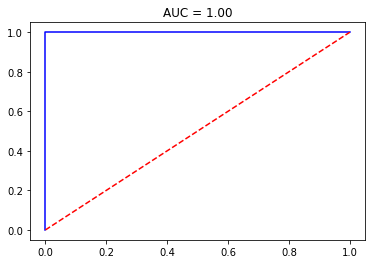

In [77]:
%%time
#Nos quedamos con el modelo "etc_pca" con GridSearchCV que nos ha dado mejor rendimiento y comprobamos el rendimiento en train y test

#Check with train and test set to see if there is overfit in model performance
y_pred = etc_pca.predict(train_x)

metricas_modelos(train_y, y_pred)

La matriz de confusión es 
[[1197    0]
 [   0 1164]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


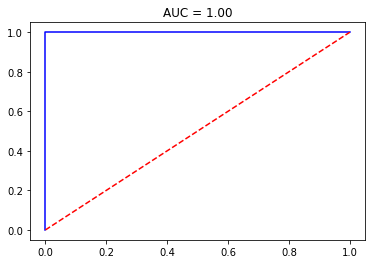

In [71]:
#Check overfit in the df test
y_pred_test = etc_pca.predict(test_x)
metricas_modelos(test_y, y_pred_test)

## Persistencia de modelos

Referencia: https://scikit-learn.org/stable/modules/model_persistence.html  
Después de entrenar un modelo y tener el que puede ser el definitivo, es recomendable tener una forma de conservar el modelo para uso futuro sin tener que volver a entrenarlo.  

- Librería `pickle` | import pickle  

In [78]:
import pickle
s = pickle.dumps(etc_pca) #Guardar modelo
etc_final = pickle.loads(s) #Cargar modelo

La matriz de confusión es 
[[2718    0]
 [   0 2791]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


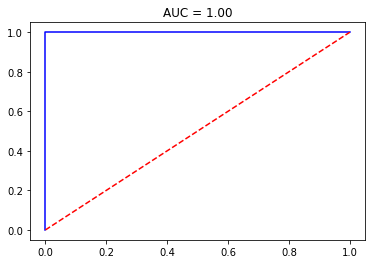

In [79]:
y_pred = etc_final.predict(train_x)

metricas_modelos(train_y, y_pred)

La matriz de confusión es 
[[1197    0]
 [   0 1164]]
Precisión: 1.0
Exactitud: 1.0
Exhaustividad: 1.0
F1: 1.0
AUC: 1.0


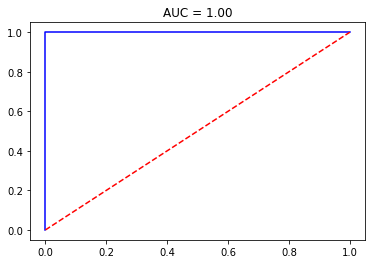

In [85]:
#Check overfit in the df test
y_pred_test = etc_final.predict(test_x)
metricas_modelos(test_y, y_pred_test)

Como se puede observar, el en modelo simple generado al principio conseguiamos AUC=0.74 habiendo aumentado el rendimiento AUC=1 con la optimización desarrollada además de disminuir la dimensionalidad lo que mejora los tiempos de procesado al escalar a producción con los datos completos.